In [1]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.genfromtxt('A2Q1.csv', delimiter=',')

In [2]:
dataset.shape

(400, 50)

# EDA

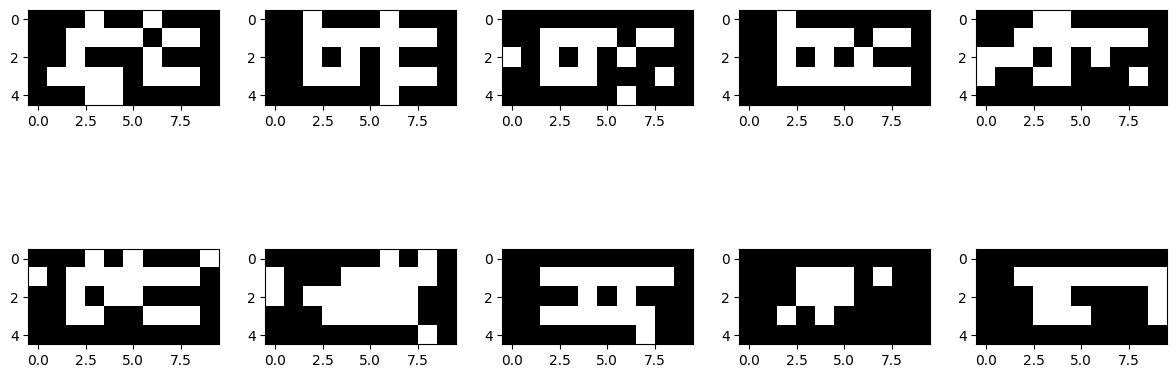

In [3]:
plt.figure(figsize=(12, 6))

idxs = np.random.choice(dataset.shape[0], 10, replace=False)

for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    plt.imshow(dataset[idx].reshape(5, 10), cmap='gray')

plt.tight_layout()
plt.show()

In [4]:
np.sum(dataset, axis=0)

array([ 35.,  37.,  43.,  34.,  38.,  46.,  45.,  33.,  36.,  49.,  45.,
        52., 285., 349., 360., 367., 354., 355., 366.,  32.,  39.,  48.,
       274., 110., 344., 119., 280.,  31.,  41.,  42.,  33.,  51., 274.,
       356., 355., 119., 271., 289., 280.,  48.,  33.,  40.,  30.,  46.,
        36.,  48.,  40.,  34.,  33.,  37.])

# EM for BMM

In [5]:
np.random.seed(42)

In [6]:
dataset.shape

(400, 50)

In [7]:
def bernoulli_mixture_em(X, K=4, max_iter=50, random_state=42):
    np.random.seed(random_state)
    N, D = X.shape

    # Initialize parameters
    pi = np.ones(K) / K
    mu = np.random.rand(K, D) * 0.5 + 0.25  # Avoid extreme values

    log_likelihoods = []

    for iteration in range(max_iter):
        # E-step
        resp = np.zeros((N, K))

        ll = 0
        for i in range(N):
            for k in range(K):
                prob = np.prod(mu[k]**X[i] * (1 - mu[k])**(1 - X[i]))
                resp[i, k] = pi[k] * prob

            ll += np.log(resp[i].sum())
        resp /= resp.sum(axis=1, keepdims=True)

        log_likelihoods.append(ll)

        # M-step
        N_k = resp.sum(axis=0)
        pi = N_k / N
        mu = (resp.T @ X) / N_k[:, np.newaxis]

    # Final LL computation
    resp = np.zeros((N, K))
    ll = 0
    for i in range(N):
        for k in range(K):
            prob = np.prod(mu[k]**X[i] * (1 - mu[k])**(1 - X[i]))
            resp[i, k] = pi[k] * prob
        ll+= np.log(resp[i].sum())
    log_likelihoods.append(ll)
    
    return pi, mu, log_likelihoods
    

In [8]:
from tqdm import tqdm

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


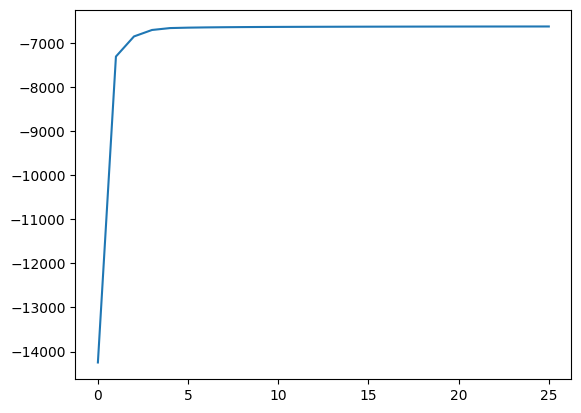

In [9]:
N_init = 100
np.random.seed(42)
seeds = np.random.randint(0, 100, N_init)

all_lls = []
for i in tqdm(range(N_init)):
    pi, mu, log_likelihoods = bernoulli_mixture_em(dataset, K=4, max_iter=25, random_state=seeds[i])
    all_lls.append(log_likelihoods)

all_lls = np.array(all_lls)
avg_lls = all_lls.mean(axis=0)

plt.plot(avg_lls)


# GMM

In [10]:
def gaussian_mixture_em(X, K=4, max_iter=50, random_state=42):
    np.random.seed(random_state)
    N, D = X.shape

    # Initialize parameters
    pi = np.ones(K) / K
    # Choose random data points as initial means
    mu = X[np.random.choice(N, K, replace=False)]
    # Initialize covariances to identity matrices
    sigma = np.array([np.eye(D) for _ in range(K)]) ## Assume given the mixture, features are independent

    log_likelihoods = []

    # Epsilon for numerical stability
    EPS = 1e-9 # To prevent singular covariance matrices during inversion
    reg_covariance = 1e-6

    for iteration in range(max_iter):
        # E-step
        resp = np.zeros((N, K))

        inv_sigma = np.zeros_like(sigma)
        dets = np.zeros(K)
        coeffs = np.zeros(K)
        
        for k in range(K):
            # Rely on regularization in M-step during previous iteration to ensure sigma is invertible
            inv_sigma[k] = np.linalg.inv(sigma[k])
            dets[k] = np.linalg.det(sigma[k])
            coeffs[k] = 1 / np.sqrt((2 * np.pi) ** D * dets[k])

        ll = 0
        for i in range(N):
            for k in range(K):
                diff = X[i] - mu[k]
                exponent = -0.5 * diff.T @ inv_sigma[k] @ diff
                prob = coeffs[k] * np.exp(exponent)
                resp[i, k] = pi[k] * prob

            row_sum = resp[i].sum()
            # Handle numerical underflow where prob is 0 for all k
            if row_sum > EPS:
                ll += np.log(row_sum)

        resp_sum = resp.sum(axis=1, keepdims=True)    
        resp /= (resp_sum + EPS)  # Avoid division by zero

        log_likelihoods.append(ll)

        # M-step
        N_k = resp.sum(axis=0)
        pi = N_k / N
        mu = (resp.T @ X) / (N_k[:, np.newaxis]+ EPS)

        for k in range(K):
            diff = X - mu[k]
            sigma[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / (N_k[k] + EPS)

            sigma[k] += reg_covariance * np.eye(D)  # Regularization to ensure positive definiteness

    # Final LL computation
    inv_sigma = np.zeros_like(sigma)
    dets = np.zeros(K)
    coeffs = np.zeros(K)
    for k in range(K):
        inv_sigma[k] = np.linalg.inv(sigma[k])
        dets[k] = np.linalg.det(sigma[k])
        coeffs[k] = 1 / np.sqrt((2 * np.pi) ** D * dets[k])

    final_ll = 0

    for i in range(N):
        prob_i = 0
        for k in range(K):
            diff = X[i] - mu[k]
            exponent = -0.5 * diff.T @ inv_sigma[k] @ diff
            prob = coeffs[k] * np.exp(exponent)
            prob_i += pi[k] * prob
        
        if prob_i > EPS:
            final_ll += np.log(prob_i)

    log_likelihoods.append(final_ll)

    return pi, mu, sigma, log_likelihoods

  0%|          | 0/100 [00:00<?, ?it/s]/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


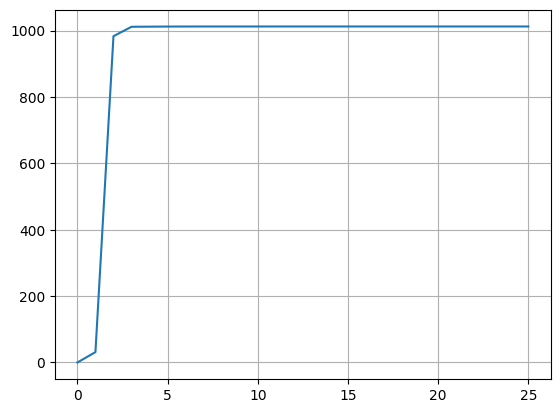

In [11]:
N_init = 100
np.random.seed(42)
seeds = np.random.randint(0, 100, N_init)

all_lls = []
for i in tqdm(range(N_init)):
    pi, mu, sigma, log_likelihoods = gaussian_mixture_em(dataset, K=4, max_iter=25, random_state=seeds[i])
    all_lls.append(log_likelihoods)

all_lls = np.array(all_lls)
avg_lls = all_lls.mean(axis=0)

plt.plot(avg_lls)
plt.grid(True)
plt.show()


## Working in Log-Space

In [12]:
def gaussian_mixture_em_robust(X, K=4, max_iter=50, random_state=42, reg_covar=1e-14):
    """
    Numerically stable implementation of EM for GMM using log-probabilities.
    """
    np.random.seed(random_state)
    N, D = X.shape

    # Initialize parameters
    pi = np.ones(K) / K
    mu = X[np.random.choice(N, K, replace=False)]
    sigma = np.array([np.eye(D) for _ in range(K)])

    log_likelihoods = []
    EPS = 1e-9 # For numerical stability

    for iteration in range(max_iter):
        
        # --- E-step (in Log-Space) ---
        
        # log_resp shape (N, K)
        # We will compute log(pi_k * N(x_i | mu_k, sigma_k))
        # = log(pi_k) + log(N(x_i | mu_k, sigma_k))
        log_resp = np.zeros((N, K))

        for k in range(K):
            # Pre-calculate inverse and log-determinant
            try:
                inv_sigma_k = np.linalg.inv(sigma[k])
                # slogdet returns (sign, log_det). 
                # Since sigma is positive definite, sign is 1.
                sign, log_det_sigma_k = np.linalg.slogdet(sigma[k])
                
                # This check handles the (rare) case where slogdet still fails
                if sign < 1 or not np.isfinite(log_det_sigma_k):
                    raise np.linalg.LinAlgError
            
            except np.linalg.LinAlgError:
                # If matrix is singular even with regularization,
                # this component is dead. Assign it -inf log-prob.
                log_resp[:, k] = -np.inf
                continue

            # This is log(coeff) from your original code
            # log( 1 / sqrt((2*pi)^D * det(sigma)) )
            # = -0.5 * (D * log(2*pi) + log_det(sigma))
            log_coeff = -0.5 * (D * np.log(2 * np.pi) + log_det_sigma_k)

            # This is the log(exponent) part for all N points at once
            # -0.5 * (X - mu_k).T @ inv(sigma_k) @ (X - mu_k)
            diff = X - mu[k]
            # (diff @ inv_sigma_k) has shape (N, D)
            # np.sum(..., axis=1) performs the dot product for each row
            log_exponent = -0.5 * np.sum((diff @ inv_sigma_k) * diff, axis=1)

            # log(pi_k) + log(N(x_i | ...))
            log_resp[:, k] = np.log(pi[k] + EPS) + log_coeff + log_exponent

        # Now, normalize the log_resp matrix to get responsibilities
        # This is the "log-sum-exp" trick for numerical stability
        
        # 1. Find the maximum log-prob for each data point
        log_resp_max = np.max(log_resp, axis=1, keepdims=True)
        
        # 2. Subtract max to prevent overflow when exponentiating
        # (This handles rows that might be all -inf)
        log_resp_shifted = log_resp - log_resp_max
        with np.errstate(over='ignore', under='ignore'):
             exp_log_resp_shifted = np.exp(log_resp_shifted)

        # 3. Sum the probabilities (which are now between 0 and 1)
        resp_sum = np.sum(exp_log_resp_shifted, axis=1, keepdims=True)
        
        # 4. Normalize to get responsibilities
        resp = exp_log_resp_shifted / (resp_sum + EPS)
        
        # Calculate log-likelihood for this iteration
        # LL = sum_i( log(sum_k( pi_k * N_k )) )
        # Using the log-sum-exp trick again:
        # LL = sum_i( log_resp_max_i + log(sum_k(exp(log_resp_shifted_ik))) )
        # LL = sum_i( log_resp_max_i + log(resp_sum_i) )
        ll = np.sum(log_resp_max.ravel() + np.log(resp_sum.ravel() + EPS))
        log_likelihoods.append(ll)


        # --- M-step (Unchanged) ---
        N_k = resp.sum(axis=0)
        
        # Add EPS to N_k to prevent division by zero if a component dies
        N_k_stable = N_k + EPS
        
        pi = N_k / N
        mu = (resp.T @ X) / N_k_stable[:, np.newaxis]
        
        for k in range(K):
            diff = X - mu[k]
            sigma[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k_stable[k]
            
            # Add regularization
            sigma[k] += np.eye(D) * reg_covar

    # Final LL is just the last one we computed
    if log_likelihoods:
        log_likelihoods.append(log_likelihoods[-1])
    else:
        # Handle case where max_iter = 0
        log_likelihoods.append(np.nan)


    return pi, mu, sigma, log_likelihoods

  0%|          | 0/100 [00:00<?, ?it/s]/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/adithya_lenka/miniconda3/envs/fml_assignment_2/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
100%|██████████| 100/100 [00:01<00:00, 90.19it/s]


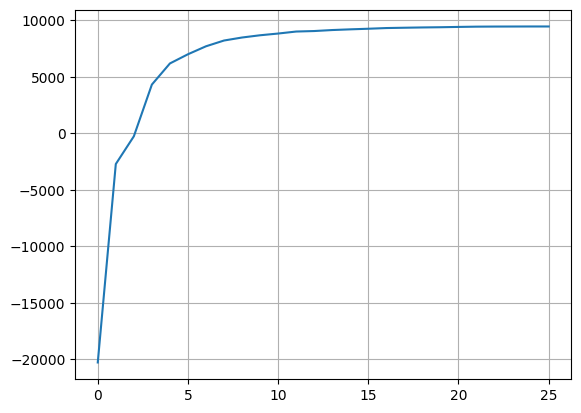

In [13]:
N_init = 100
np.random.seed(42)
seeds = np.random.randint(0, 100, N_init)

all_lls = []
for i in tqdm(range(N_init)):
    pi, mu, sigma, log_likelihoods = gaussian_mixture_em_robust(dataset, K=4, max_iter=25, random_state=seeds[i])
    all_lls.append(log_likelihoods)

all_lls = np.array(all_lls)
avg_lls = all_lls.mean(axis=0)

plt.plot(avg_lls)
plt.grid(True)
plt.show()


# K-Means

In [14]:
def kmeans(X, K=4, max_iter=50, random_state=42):
    np.random.seed(random_state)
    N, D = X.shape

    # Initialize centroids by randomly selecting K data points
    centroids = X[np.random.choice(N, K, replace=False)]
    
    objective_values = [] # Sum of squared distances from cluster centroid

    for iteration in range(max_iter):
        distances = np.sum((X[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2, axis=2)  # Shape (N, K)
        cluster_assignments = np.argmin(distances, axis=1)  # Shape (N,)

        obj = distances[np.arange(N), cluster_assignments].sum()
        objective_values.append(obj)

        for k in range(K):
            points_in_cluster = X[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                centroids[k] = points_in_cluster.mean(axis=0)
            else:
                # If a cluster gets no points, reinitialize its centroid randomly
                centroids[k] = X[np.random.choice(N)]
    
    return centroids, cluster_assignments, objective_values    

100%|██████████| 10/10 [00:00<00:00, 376.38it/s]


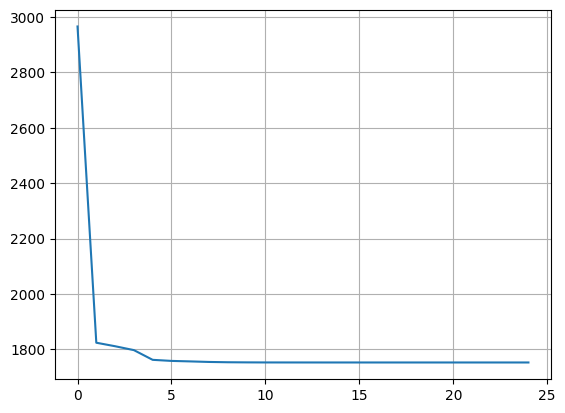

In [15]:
N_init = 10
np.random.seed(42)
seeds = np.random.randint(0, 100, N_init)

all_lls = []
for i in tqdm(range(N_init)):
    centroids, assignments, objective_values = kmeans(dataset, K=4, max_iter=25, random_state=seeds[i])
    all_lls.append(objective_values)

all_lls = np.array(all_lls)
avg_lls = all_lls.mean(axis=0)

plt.plot(avg_lls)
plt.grid(True)
plt.show()
